### Overview

I chose a model that was designed for general purpose sequence classification tasks.
While not specifically designed for entity recognition it was easily trainable on a relatively small dataset.


In [2]:
import pandas as pd
import numpy as np
import json
import ast
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizer
import torch
from torch.utils.data import Dataset
from transformers import AlbertForSequenceClassification, AlbertTokenizer
from transformers import TrainingArguments, Trainer
import pickle
import os
from sklearn.metrics import classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

2024-10-15 17:52:32.312967: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 17:52:32.316244: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 17:52:32.326308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 17:52:32.342370: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 17:52:32.347155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 17:52:32.359386: I tensorflow/core/platform/cpu_feature_gu

In [3]:
# Loading data

data = pd.read_csv('user_queries.csv')

In [4]:
# Preprocssing

data["json"] = data["json"].str.replace("\'", "\"")
data["json"] = data["json"].str.replace("True", "\"True\"")
data["json"] = data["json"].str.replace("False", "\"False\"")
data.head()

,question,json
0,Find all calls made using 3G technology.,"{""entityType"": ""CDR"", ""statements"": [{""type"": ..."
1,List all Reddit comments posted yesterday with...,"{""entityType"": ""Web Activity"", ""statements"": [..."
2,Show me investigations that are either open or...,"{""entityType"": ""Investigation"", ""statements"": ..."
3,Find all insights related to the witness Jane ...,"{""entityType"": ""Insight"", ""statements"": [{""typ..."
4,List all web activities updated in the last da...,"{""entityType"": ""Web Activity"", ""statements"": [..."


In [5]:
# Extract labels (Entities)

def extract_entities(json_str):

    try:
        json_obj = json.loads(json_str)
        entities = []

        # Extract entityType
        if 'entityType' in json_obj:
            entities.append(json_obj['entityType'])
        
        statements_list = json_obj['statements']
        relationTargetType_location = [i for i, item in enumerate(statements_list) if 'relationTargetType' in item['parameters']]

        # Extract relationTargetType if present
        if relationTargetType_location:
            entities.extend(statements_list[relationTargetType_location[0]]['parameters']['relationTargetType'])

        return entities
    except json.JSONDecodeError:
        return []
    
data['entities'] = data['json'].apply(extract_entities)
data[['question', 'entities']].head()

,question,entities
0,Find all calls made using 3G technology.,[CDR]
1,List all Reddit comments posted yesterday with...,[Web Activity]
2,Show me investigations that are either open or...,[Investigation]
3,Find all insights related to the witness Jane ...,[Insight]
4,List all web activities updated in the last da...,[Web Activity]


In [6]:
# Keeping only observations with labels

data = data.loc[data["entities"].str.len() > 0, :].copy()

In [7]:
# Checking sequence length distribution

seq_len = data["question"].str.len()
print(seq_len.quantile(np.linspace(0, 1, 11)))

# Max sequence length
max_sequence_length = seq_len.max()
print(f"Max sequency length is: {max_sequence_length}")

0.0     19.0
0.1     44.0
0.2     51.0
0.3     57.0
0.4     63.0
0.5     68.0
0.6     74.0
0.7     79.0
0.8     85.0
0.9     94.0
1.0    138.0
Name: question, dtype: float64
Max sequency length is: 138


In [8]:
# Splitting data

inputs = data["question"]
labels = data["entities"].apply(lambda x: '|'.join(sorted(x)))# Sorting to avoid duplicates

# Train test split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs, labels, test_size=0.2, stratify=labels, random_state=42
)

# Train validation split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_inputs, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Checking stratification
train_vc = train_labels.value_counts()
val_vc = val_labels.value_counts()
test_vc = test_labels.value_counts()

entity_dist = pd.concat([
    (train_vc/train_vc.sum()).sort_index(), 
    (val_vc/val_vc.sum()).sort_index(),
    (test_vc/test_vc.sum()).sort_index()], axis=1)
display(entity_dist)

In [9]:
# Importing model and tokenizing

model_name = "twmkn9/albert-base-v2-squad2"
tokenizer = AlbertTokenizer.from_pretrained(model_name)
# Defining text encoder
max_sequence_length = 150
def encode_text(text):
    return tokenizer(
        text,
        max_length=max_sequence_length,
        truncation=True, 
        padding='max_length', 
        return_tensors="pt"
    )
# Encoding text
train_encodings = encode_text(train_inputs.to_list())
val_encodings = encode_text(val_inputs.to_list())
test_encodings = encode_text(test_inputs.to_list())

# labels encoding and converting to tensors
unique_labels = list(sorted(list(set(labels))))
train_labels_tensor = torch.tensor([unique_labels.index(lbl) for lbl in train_labels])
val_labels_tensor = torch.tensor([unique_labels.index(lbl) for lbl in val_labels])
test_labels_tensor = torch.tensor([unique_labels.index(lbl) for lbl in test_labels])

In [10]:
# Creating entity dataset

class EntityDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

In [11]:
# Create dataset objects for training and validation

train_dataset = EntityDataset(train_encodings, train_labels_tensor)
val_dataset = EntityDataset(val_encodings, val_labels_tensor)
test_dataset = EntityDataset(test_encodings, test_labels_tensor)

In [12]:
# Saving setitngs

should_save = False
if should_save:
    base_output_dir = "./results"
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join(base_output_dir, f"run_{current_time}")
    os.makedirs(output_dir, exist_ok=True)
else:
    output_dir = "./results/run_20241015_135901"

In [13]:
# Defining training args

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    save_total_limit=2,
    load_best_model_at_end=True,
    weight_decay=0.01,
    no_cuda=True,
)

In [14]:
# Assuming Training is already done and we have models locally

if os.path.exists(output_dir) and os.path.exists(output_dir + "/spiece.model"):
    print(f"Loading model from {output_dir}")
    model = AlbertForSequenceClassification.from_pretrained(output_dir)
    tokenizer = AlbertTokenizer.from_pretrained(output_dir)

    print(f"Model loaded from {output_dir}")
    print(f"Model: {model}")

    # Reload training dataset
    with open(f"{output_dir}/train_dataset.pkl", "rb") as f:
        train_dataset = pickle.load(f)

    # Reload validation dataset
    with open(f"{output_dir}/val_dataset.pkl", "rb") as f:
        val_dataset = pickle.load(f)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
    )
else:
    print('saving training dataset')
    # Save training dataset
    with open(f"{output_dir}/train_dataset.pkl", "wb") as f:
        pickle.dump(train_dataset, f)

    # Save validation dataset
    with open(f"{output_dir}/val_dataset.pkl", "wb") as f:
        pickle.dump(val_dataset, f)

    print(f"Training new model")
    model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_labels))

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
    )
    trainer.train()


print(model)

Loading model from ./results/run_20241015_135901
Model loaded from ./results/run_20241015_135901
Model: AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_f

In [15]:
# Saving new models

if should_save:
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model and tokenizer saved to {output_dir}")
else:
    print(f"A model was loaded from file {output_dir}")

A model was loaded from file ./results/run_20241015_135901


In [30]:
# Evaluating the on a test set


def evaluate_model(trainer, test_dataset, unique_labels):
    # get predictions
    preds = trainer.predict(test_dataset)

    # covert ML output to labels
    preds_labels = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()

    # extract TRUE labels
    true_labels = [test_dataset[i]['labels'].item() for i in range(len(test_dataset))]

    #compute F1 score
    # f1 = f1_score(true_labels, preds_labels, average='weighted')
    f1 = f1_score(true_labels, preds_labels, average='micro')
    cm = confusion_matrix(true_labels, preds_labels, labels=None, sample_weight=None)

    # print report
    print("Classification Report:\n")
    print(classification_report(true_labels, preds_labels, target_names=unique_labels))
    print(f"Micro f1 score: {f1:0.2f}")
    
    return cm

cm = evaluate_model(trainer, test_dataset, unique_labels)

Classification Report:

                        precision    recall  f1-score   support

                   CDR       0.92      1.00      0.96        34
             CDR|Phone       1.00      0.75      0.86        12
         EVisa Request       0.00      0.00      0.00         2
               Insight       1.00      0.91      0.95        11
         Investigation       1.00      1.00      1.00        15
                Person       0.91      1.00      0.95        10
                 Phone       0.78      0.88      0.82        16
                Report       1.00      1.00      1.00        14
          Web Activity       0.60      0.50      0.55        12
Web Activity|Web Actor       0.71      0.45      0.56        11
             Web Actor       0.61      0.92      0.73        12

              accuracy                           0.86       149
             macro avg       0.78      0.76      0.76       149
          weighted avg       0.85      0.86      0.85       149

Micro f1 scor

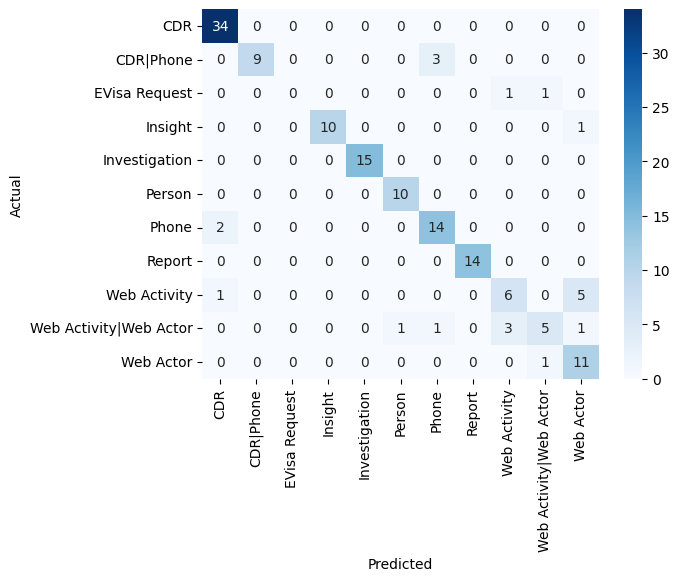

In [29]:
# Test confusion matrix
cm = pd.DataFrame(cm, columns = unique_labels, index=unique_labels)
sns.heatmap(cm, annot=True, fmt=".2g", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [34]:
# Conclusions from model performances:

# - The model performes well with the following classes: 
#    - CDR 
#    - Insight
#    - Investigation
#    - Person
#    - Phone
#    - Report
#    - Web Actor

# Other classes get confused as follows:
# - 'Web Activity' is sometimes confused with 'Web Actor'
# - 'Web Activity|Web Actor' is sometimes confused with 'Web Activity'
# - 'CDR|Phone' is sometimes confused with 'Phone'
# - 'EVisa Request' has very low performance, probably due to bein very rare class (only 2 obs in test)

### Inference (Examples)

In [38]:
# Inference Examples
def infer(model, tokenizer, query, unique_labels):
    # Tokenize the input query
    inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True)

    # Perform inference using the model
    outputs = model(**inputs)

    # Get the predicted label ID
    predicted_label_id = torch.argmax(outputs.logits, dim=1).item()

    # Convert the label ID back to the original label name
    predicted_label = unique_labels[predicted_label_id]

    return list(predicted_label.split('|'))


# Test the inference function with a sample query

# Example 1
print("Example 1 \n")
sample_query = "Are there any insights that contain 'DNA evidence' or 'fingerprint match' in the content?"
predicted_entity = infer(model, tokenizer, sample_query, unique_labels)
print(f"Query: {sample_query}")
print(f"Predicted Entity Type: {predicted_entity}")

print('\n' + "-"*50 + '\n')

# Example 2 (from pdf)
print("Example 2 \n")
sample_query = "Which SMS message was sent from suspecious phones to 0549876543 containing the word 'urgent'"
predicted_entity = infer(model, tokenizer, sample_query, unique_labels)
print(f"Query: {sample_query}")
print(f"Predicted Entity Type: {predicted_entity}")

print('\n' + "-"*50 + '\n')

# Example 3 (Bad prediction)
print("Example 3 \n")
sample_query = "Find all visa applicants who used a Gmail address"
predicted_entity = infer(model, tokenizer, sample_query, unique_labels)
print(f"Query: {sample_query}")
print(f"Predicted Entity Type: {predicted_entity}")


Example 1 

Query: Are there any insights that contain 'DNA evidence' or 'fingerprint match' in the content?
Predicted Entity Type: ['Insight']

--------------------------------------------------

Example 2 

Query: Which SMS message was sent from suspecious phones to 0549876543 containing the word 'urgent'
Predicted Entity Type: ['CDR', 'Phone']

--------------------------------------------------

Example 3 

Query: Find all visa applicants who used a Gmail address
Predicted Entity Type: ['EVisa Request']


In [ ]:
# Improvements
